In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


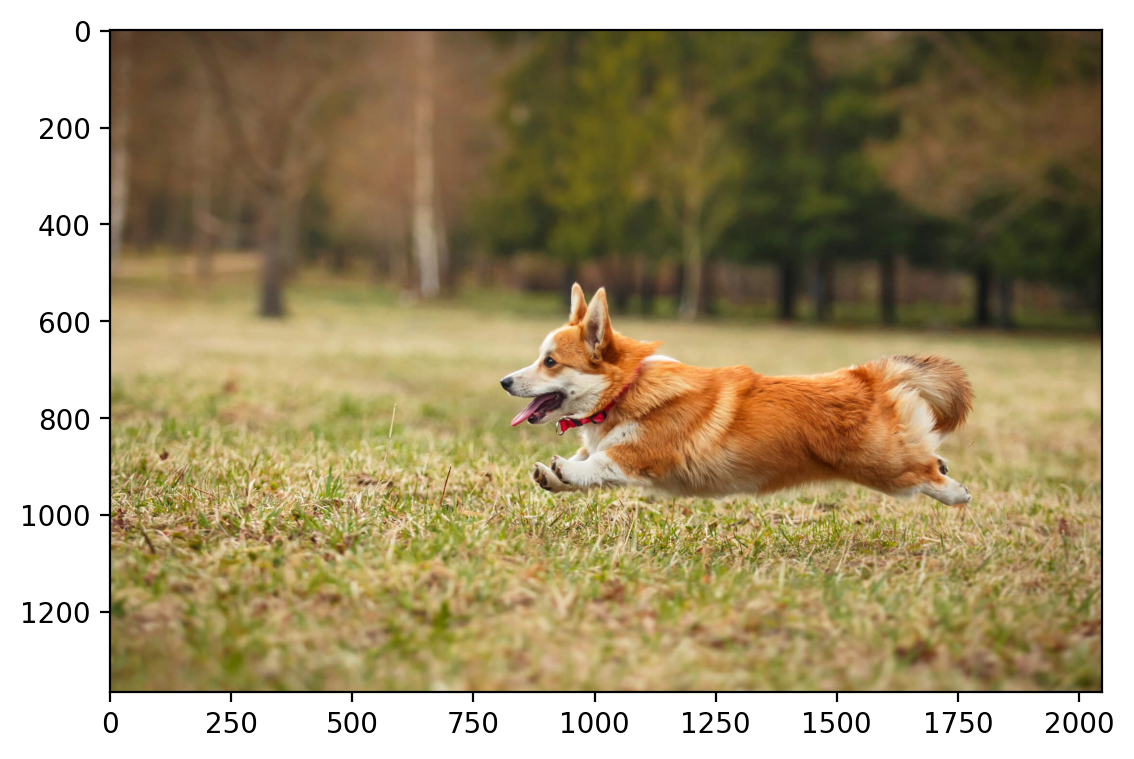

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

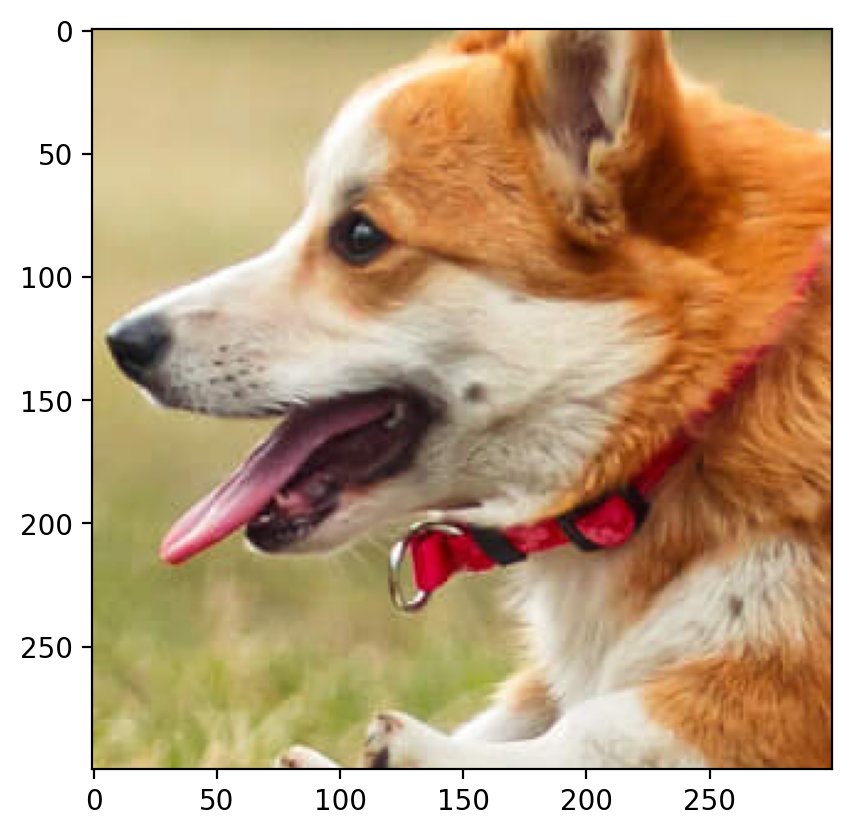

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler()
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [6]:
original_image = crop.clone()

In [7]:
def mask_image(img, prop, mask_size):
    img_copy = img.clone()
    
    # Get the dimensions of the image
    _, h, w = img.shape
    
    # Ensure the mask size is not larger than the image dimensions
    mask_size = min(mask_size, min(h, w))
    
    # Flatten the image and generate indices for the pixels
    flat_indices = torch.arange(h * w)
    
    # Randomly choose indices for the missing pixels
    masked_indices = random.sample(flat_indices.tolist(), mask_size * mask_size)
    
    # Convert the indices to 2D coordinates
    masked_coords = [(idx // w, idx % w) for idx in masked_indices]
    
    # Mask the selected pixels
    for y, x in masked_coords:
        img_copy[:, y, x] = float('nan')
    
    return img_copy


In [8]:
def fill_nans_with_neighbors(A):
    mask = ~torch.isnan(A)

    for i in range(A.shape[1]):
        mask_rows = mask[:, i]
        unknown_rows = ~mask_rows

        if unknown_rows.any():
            # Forward fill using the previous (i-1th) column if i is greater than 0
            if i > 0:
                A[unknown_rows, i] = A[unknown_rows, i - 1].clone().detach()
            # Alternatively, you can handle the case when i is 0 (first column) separately
            # else:
            #     A[unknown_rows, i] = some_default_value  # Choose an appropriate default value

    return A


In [9]:
def plot_reconstructed_and_original_image(original_img, img_with_missing_patch, finalImg, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().detach().numpy())
    #ax0.imshow(original_image.reshape(300,300,3).cpu().numpy())
    ax0.set_title("Original Image")


    ax1.imshow(rearrange(img_with_missing_patch, 'c h w -> h w c').cpu().detach().numpy())
    #ax1.imshow(img_with_missing_patch.reshape(300,300,3).cpu().numpy())
    ax1.set_title("Image with missing patch")
    #ax2.imshow(finalImg.reshape(300,300,3).cpu().numpy())
    ax2.imshow(rearrange(finalImg, 'c h w -> h w c').cpu().detach().numpy())
    ax2.set_title(f"Reconstructed Image")
    squared_error = torch.square(rearrange(finalImg, 'c h w -> h w c').cpu() - rearrange(original_img, 'c h w -> h w c').cpu())
    mse = torch.mean(squared_error)

    # Calculate the root mean squared error
    rmse = torch.sqrt(mse)

    # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)
    Errors["Type"].append(title)
    Errors["RMSE"].append(rmse.cpu().detach().numpy())
    Errors["Peak SNR"].append(psnr.cpu().detach().numpy())
    print(f"Type: {title} , RMSE: {rmse}, PSNR: {psnr} \n")

# Calculate the PSNR
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [14]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B using Alternating Least Squares (ALS)"""
    A = A.to(device)

    # Fill NaN values with values from the previous column
    A = fill_nans_with_neighbors(A)

    # Randomly initialize A and B for each channel with the same dtype as A
    dtype = A.dtype
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device, dtype=dtype)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device, dtype=dtype)

    for i in range(20):    
        for j in range(H.shape[1]):
            mask_rows = ~torch.isnan(A[:, j])
            h_j = torch.linalg.lstsq(W[mask_rows], A[:, j][mask_rows]).solution
            with torch.no_grad():
                H[:, j] = h_j

        A_ = A.t()
        W_ = W.t()
        H_ = H.t()
        for j in range(W_.shape[1]):
            mask_rows = ~torch.isnan(A_[:, j])
            w_j = torch.linalg.lstsq(H_[mask_rows], A_[:, j][mask_rows]).solution
            with torch.no_grad():
                W_[:, j] = w_j

        W = W_.t()
        if i % 10 == 0:
            print(f"epoch {i}")

    # Compute the final loss
    diff_matrix = torch.mm(W, H) - A
    loss = torch.norm(diff_matrix)
    return W, H, loss

In [15]:
Errors={'Type':[],'RMSE': [],'Peak SNR':[]}

In [16]:
import random


epoch 0
epoch 10
epoch 0
epoch 10
epoch 0
epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 20) , RMSE: 0.0064497403133756, PSNR: 21.90457771060611 

ErrorDF:                                                  Type                RMSE  \
0  Reconstructed Image for Single Color (Patch Si...  0.0064497403133756   

            Peak SNR  
0  21.90457771060611  


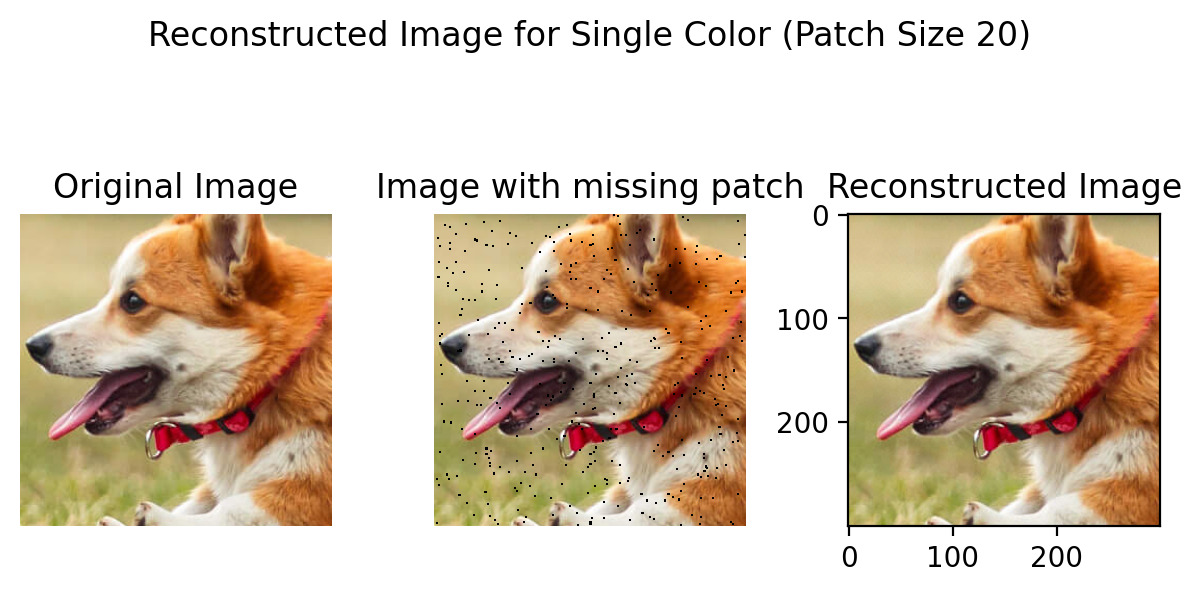

In [17]:
start_x = [0]
start_y = [0]
label = ["Single Color"]
patch_sizes = [20]  # Different patch sizes (N)

for patch_size in patch_sizes:
    for idx, i in enumerate(start_x):
        img_with_missing_patch = mask_image(crop, prop=0.1, mask_size=patch_size)
        Wr, Hr, lossr = factorize(img_with_missing_patch[0], 100, device=device)
        Wg, Hg, lossg = factorize(img_with_missing_patch[1], 100, device=device)
        Wb, Hb, lossb = factorize(img_with_missing_patch[2], 100, device=device)
        
        finalImg = torch.Tensor(3, 300, 300)
        finalImg[0] = torch.mm(Wr, Hr)
        finalImg[1] = torch.mm(Wg, Hg)
        finalImg[2] = torch.mm(Wb, Hb)
        
        plot_reconstructed_and_original_image(crop, img_with_missing_patch, finalImg, title=f"Reconstructed Image for {label[idx]} (Patch Size {patch_size})")

# Assuming Errors and ErrorDF are defined globally or within the context of the code.
ErrorDF = pd.DataFrame(Errors)
ErrorDF.reset_index(drop=True, inplace=True)

print("ErrorDF: ", ErrorDF)

epoch 0
epoch 10
epoch 0
epoch 10
epoch 0
epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 30) , RMSE: 0.006778192763829388, PSNR: 21.68886084498787 

epoch 0
epoch 10
epoch 0
epoch 10
epoch 0
epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 40) , RMSE: 0.007066608656875503, PSNR: 21.50788958899723 

epoch 0
epoch 10
epoch 0
epoch 10
epoch 0
epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 60) , RMSE: 0.008385231509111725, PSNR: 20.764849423910185 

epoch 0
epoch 10
epoch 0
epoch 10
epoch 0
epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 80) , RMSE: 0.009854603563156442, PSNR: 20.06360842089421 

ErrorDF:                                                  Type                  RMSE  \
0  Reconstructed Image for Single Color (Patch Si...    0.0064497403133756   
1  Reconstructed Image for Single Color (Patch Si...  0.006778192763829388   
2  Reconstructed Image for Single Color (Patch Si...  0.007066608656875503   
3  Reconstructed Image for Single Color (Patch Si...  0.008385231509111725   
4  Reconstructed Image for Single Color (Patch Si...  0.009854603563156442   

             Peak SNR  
0   21.90457771060611  
1   21.68886084498787  
2   21.50788958899723  
3  20.764849423910185  
4   20.06360842089421  


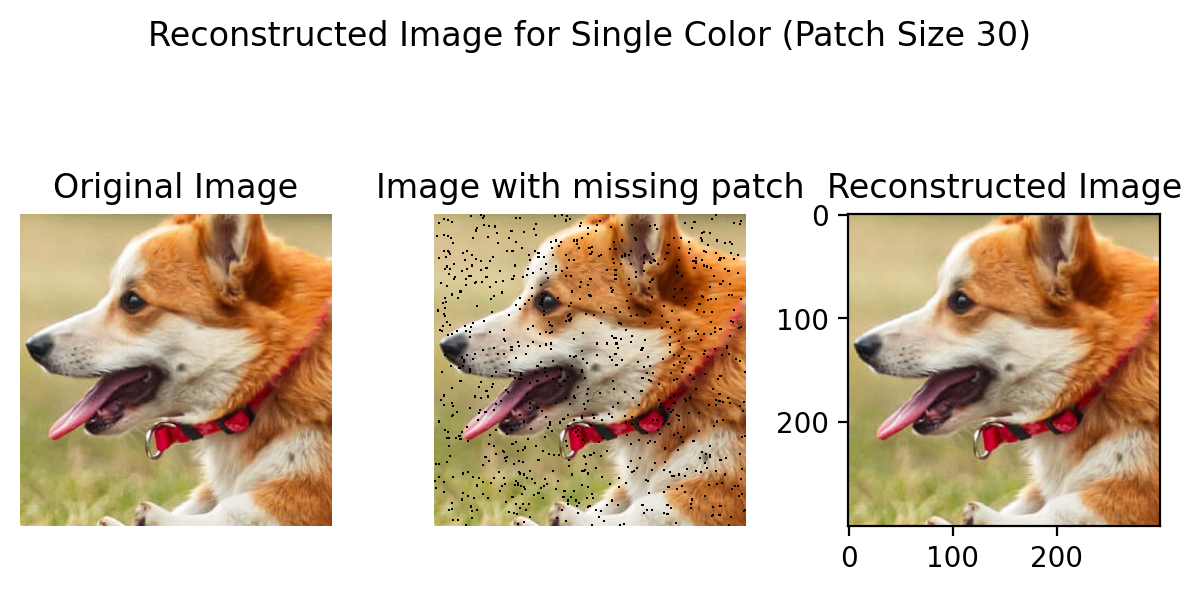

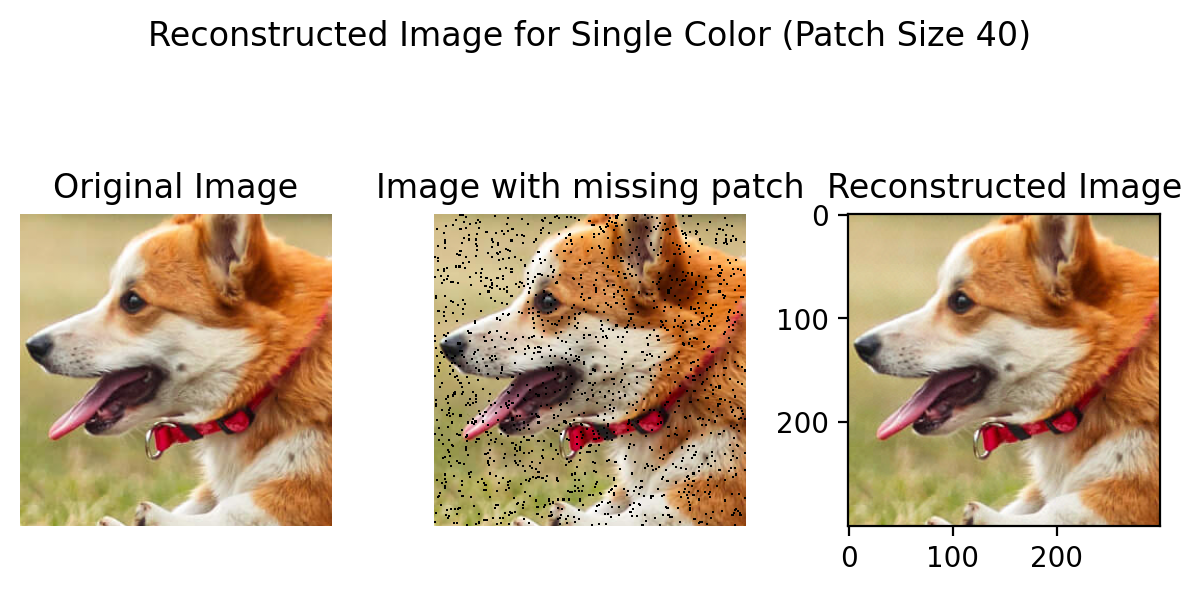

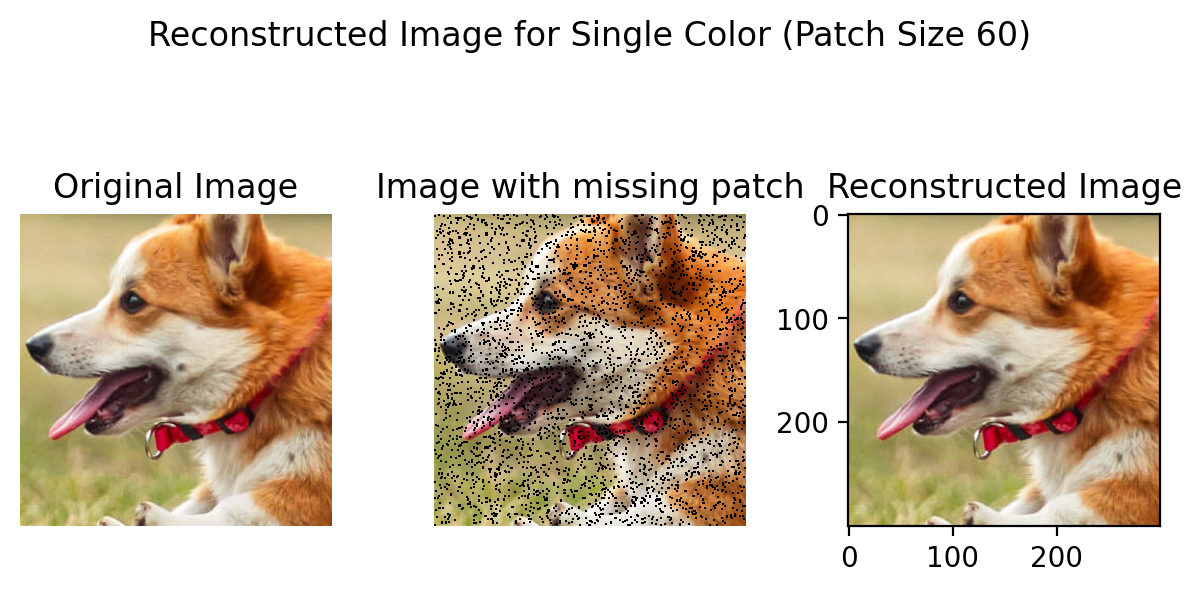

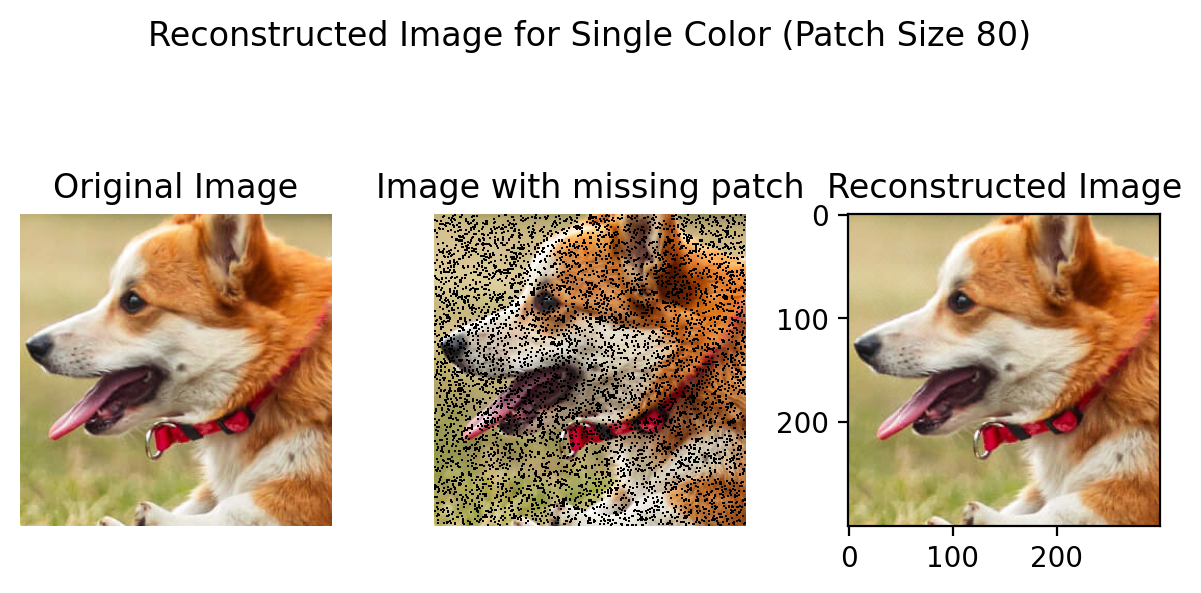

In [18]:
start_x = [0]
start_y = [0]
label = ["Single Color"]
patch_sizes = [30, 40, 60, 80]  # Different patch sizes (N)

for patch_size in patch_sizes:
    for idx, i in enumerate(start_x):
        img_with_missing_patch = mask_image(crop, prop=0.1, mask_size=patch_size)
        Wr, Hr, lossr = factorize(img_with_missing_patch[0], 100, device=device)
        Wg, Hg, lossg = factorize(img_with_missing_patch[1], 100, device=device)
        Wb, Hb, lossb = factorize(img_with_missing_patch[2], 100, device=device)
        
        finalImg = torch.Tensor(3, 300, 300)
        finalImg[0] = torch.mm(Wr, Hr)
        finalImg[1] = torch.mm(Wg, Hg)
        finalImg[2] = torch.mm(Wb, Hb)
        
        plot_reconstructed_and_original_image(crop, img_with_missing_patch, finalImg, title=f"Reconstructed Image for {label[idx]} (Patch Size {patch_size})")

# Assuming Errors and ErrorDF are defined globally or within the context of the code.
ErrorDF = pd.DataFrame(Errors)
ErrorDF.reset_index(drop=True, inplace=True)

print("ErrorDF: ", ErrorDF)